# Stock Analysis with EDGAR Crawling

In [1]:
import numpy as np
import pandas as pd
import platform

# Graph settings
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('axes', unicode_minus=False)
plt.style.use('ggplot')

if platform.system() == 'Darwin':  # macOS
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
    plt.rc('font', family='Malgun Gothic')
else:  # Linux or other OS
    plt.rc('font', family='DejaVu Sans')

In [2]:
# %% Get EdgarClient
from sec_edgar_api import EdgarClient
edgar = EdgarClient(user_agent="<Sample Company Name> <Admin Contact>@<Sample Company Domain>")

In [3]:
# %% Load the Data
CIK = {
    "AAPL": "0000320193",
    "ADBE": "0000796343",
    "AMD": "0000002488",
    "AMZN": "0001018724",
    "BRK-B": "0001067983",
    "CPNG": "0001834584",
    "FB": "0001326801",
    "GOOG": "0001652044",
    "GOOGL": "0001652044",
    "INTC": "0000050863",
    "KO": "0000021344",
    "LOGI": "0001032975",
    "MA": "0001141391",
    "MSFT": "0000789019",
    "MMM": "0000066740",
    "NFLX": "0001065280",
    "NVDA": "0001045810",
    "PEP": "0000077476",
    "SBUX": "0000829224",
    "TSLA": "0001318605",
    "V": "0001403161"
}

## 0. Helper Functions

### Net Income

In [4]:
# %% Annual Net Income(Loss)
def annual_net_income(facts):
    if 'NetIncomeLoss' in facts['us-gaap'].keys():
        ni_var = 'NetIncomeLoss'
    elif 'NetIncomeLossAvailableToCommonStockholdersBasic' in facts['us-gaap'].keys():
        ni_var = 'NetIncomeLossAvailableToCommonStockholdersBasic'
    else:
        return False

    title = facts['us-gaap'][ni_var]['label']
    description = facts['us-gaap'][ni_var]['description']

    date = []
    net_income = []

    for report in facts['us-gaap'][ni_var]['units']['USD']:
        try:
            frame = report['frame']

            if len(frame) == 6:
                date.append(report['end'])
                net_income.append(report['val'])
        except:
            pass

    df_net_income = pd.DataFrame({'date': date, 'net_income': net_income})

    return df_net_income, title, description

In [52]:
def plot_annual_net_income(df_net_income, title, description, ymin, ymax, ystep, ax):
    df_net_income.plot(kind='bar', x='date', y='net_income', 
                       ax=ax, color='blue', alpha=0.5)

    ax.set_title(f'{ticker}\n{title}', fontsize=14)
    ax.set_xticks(ticks=df_net_income.index, labels=df_net_income.date.str[:4], rotation=0)
    ax.set_yticks(ticks=np.arange(ymin, ymax * 1e6, ystep * 1e6), labels=[str(x) for x in np.arange(ymin, ymax, ystep)])
    ax.set_ylabel('USD in milllions')
    
    return ax

In [64]:
def plot_net_income_growth(df_net_income, title, description, ymin, ymax, ystep, ax):
    sns.barplot(data=df_net_income, x='date', y='net_income_growth', 
                color='blue', alpha=0.5, ax=ax)

    ax.set_title(f'{ticker}\n{title}\n{description}', fontsize=12)
    ax.set_xticks(ticks=df_net_income.index, labels=df_net_income.date.str[:4], rotation=0)
    ax.set_ylabel('Income Growth(%)')
    ax.set_yticks(ticks=np.arange(ymin, ymax, ystep), labels=[str(x) for x in np.arange(ymin, ymax, ystep)])
    ax.set_ylim((ymin,ymax))

    return ax

### Dividends

In [6]:
# %% Dividends
def annual_dividends(facts):

    if 'PaymentsOfDividends' in facts['us-gaap'].keys():
        div_var = 'PaymentsOfDividends'
    elif 'PaymentsOfDividendsCommonStock' in facts['us-gaap'].keys():
        div_var = 'PaymentsOfDividendsCommonStock'
    elif 'PaymentsOfDividendsPreferredStock' in facts['us-gaap'].keys():
        div_var = 'PaymentsOfDividendsPreferredStock'
    else:
        return False

    if div_var:
        title = facts['us-gaap'][div_var]['label']
        description = facts['us-gaap'][div_var]['description']

        date = []
        dividends = []

        for report in facts['us-gaap'][div_var]['units']['USD']:
            try:
                frame = report['frame']

                if len(frame) == 6:
                    date.append(report['end'])
                    dividends.append(report['val'])
            except:
                pass

        df_dividends = pd.DataFrame({'date': date, 'dividends': dividends})

        return df_dividends, title, description

In [7]:
def plot_annual_dividends(df_dividends, title, description, ymin, ymax, ystep):
    fig, axes = plt.subplots(1, 1, figsize=(12, 6))

    df_dividends.plot(kind='bar', x='date', y='dividends', ax=axes, color='blue', alpha=0.5)
    plt.title(ticker.upper() + '\n' + title, fontsize=12)
    plt.xticks(ticks=df_dividends.index, labels=df_dividends.date.str[:4], rotation=0)
    plt.yticks(ticks=np.arange(ymin, ymax * 1e6, ystep * 1e6), labels=[str(x) for x in np.arange(ymin, ymax, ystep)])
    plt.ylabel('USD($)')
    plt.tight_layout()


def plot_dividends_growth(df_dividends, title, description, ymin, ymax, ystep):
    fig, axes = plt.subplots(1, 1, figsize=(12, 6))

    sns.barplot(data=df_dividends, x='date', y='dividends_growth', color='blue', alpha=0.5, ax=axes)

    plt.title(f'{ticker}\n{title}\n{description}', fontsize=12)
    plt.ylabel('Income Growth(%)')
    plt.yticks(ticks=np.arange(ymin, ymax, ystep), labels=[str(x) for x in np.arange(ymin, ymax, ystep)])
    plt.ylim((ymin,ymax))

    plt.tight_layout()

## 1. Portfolio

### AAPL

In [66]:
ticker = 'AAPL'
facts = edgar.get_company_facts(cik=CIK[ticker.upper()])['facts']

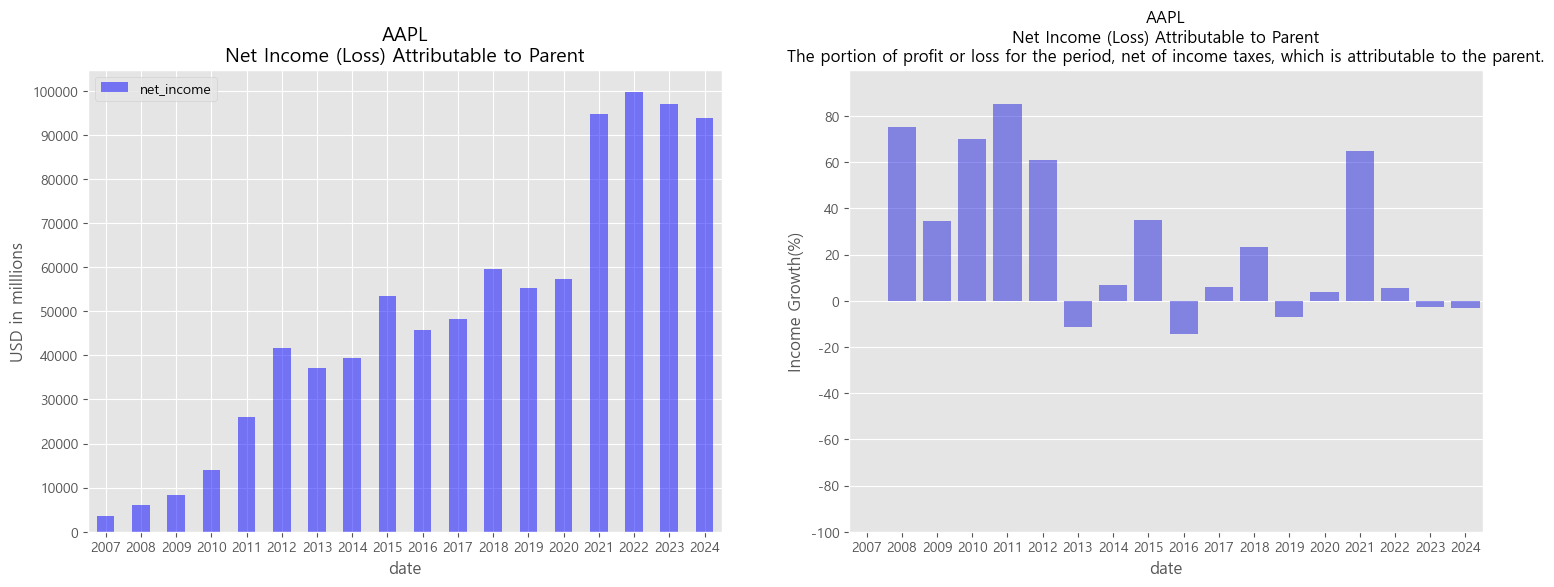

In [67]:
# Income Graphs
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Annual Net Income
df_net_income, title, description =  annual_net_income(facts)

plot_annual_net_income(df_net_income=df_net_income, title=title, description=description,
                       ymin=0, ymax=110000, ystep=10000, ax=axes[0])

# Net Income Growth
df_net_income['net_income_growth'] = df_net_income['net_income'].diff() / df_net_income['net_income'].abs().shift() * 100

plot_net_income_growth(df_net_income=df_net_income, title=title, description=description,
                       ymin=-100, ymax=100, ystep=20, ax=axes[1])

# Visualize
plt.show()

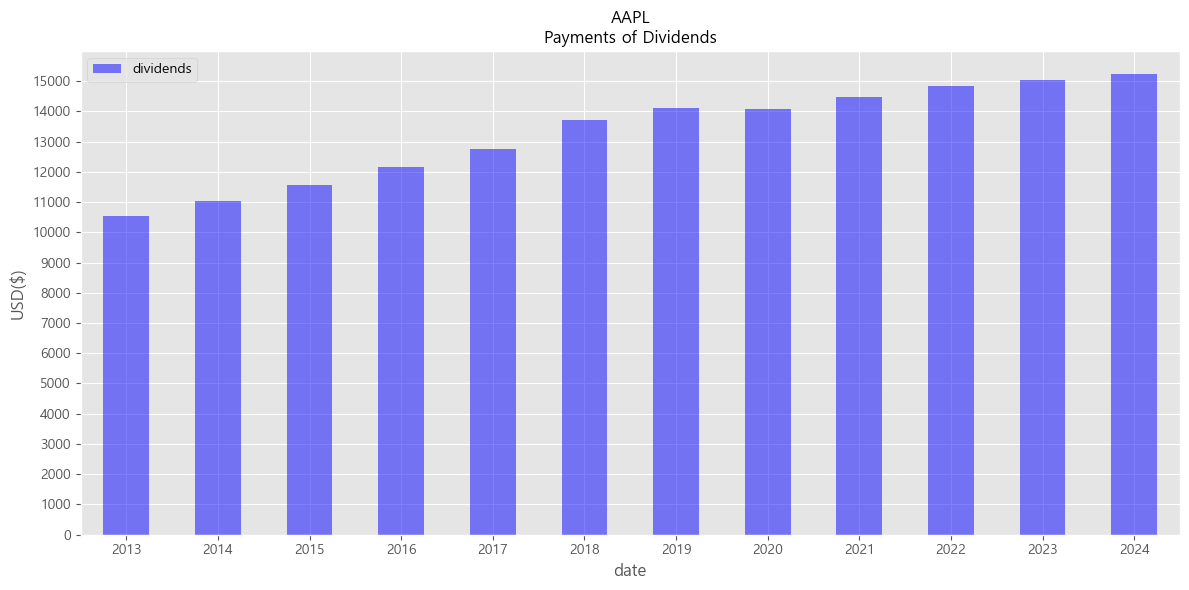

In [31]:
try:
    df_dividends, title, description = annual_dividends(facts)

    plot_annual_dividends(df_dividends, title, description, 
                        ymin=0, ymax=16000, ystep=1000)
except:
    print(f'{ticker} does not pay dividends')

### AMZN

In [68]:
ticker = 'AMZN'
facts = edgar.get_company_facts(cik=CIK[ticker.upper()])['facts']

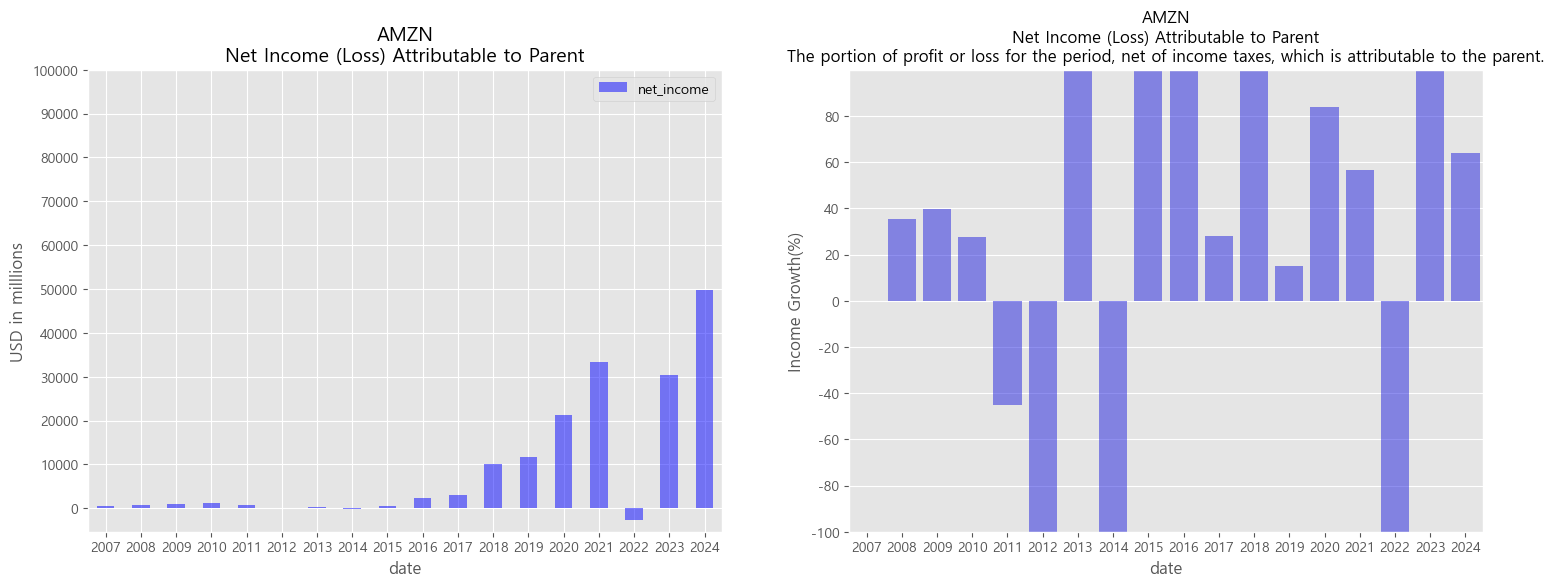

In [69]:
# Income Graphs
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Annual Net Income
df_net_income, title, description =  annual_net_income(facts)

plot_annual_net_income(df_net_income=df_net_income, title=title, description=description,
                       ymin=0, ymax=110000, ystep=10000, ax=axes[0])

# Net Income Growth
df_net_income['net_income_growth'] = df_net_income['net_income'].diff() / df_net_income['net_income'].abs().shift() * 100

plot_net_income_growth(df_net_income=df_net_income, title=title, description=description,
                       ymin=-100, ymax=100, ystep=20, ax=axes[1])

# Visualize
plt.show()

In [45]:
try:
    df_dividends, title, description = annual_dividends(facts)

    plot_annual_dividends(df_dividends, title, description, 
                        ymin=0, ymax=16000, ystep=1000)
except:
    print(f'{ticker} does not pay dividends')

AMZN does not pay dividends


### GOOG, GOOGL


In [70]:
ticker = 'GOOG'
facts = edgar.get_company_facts(cik=CIK[ticker.upper()])['facts']

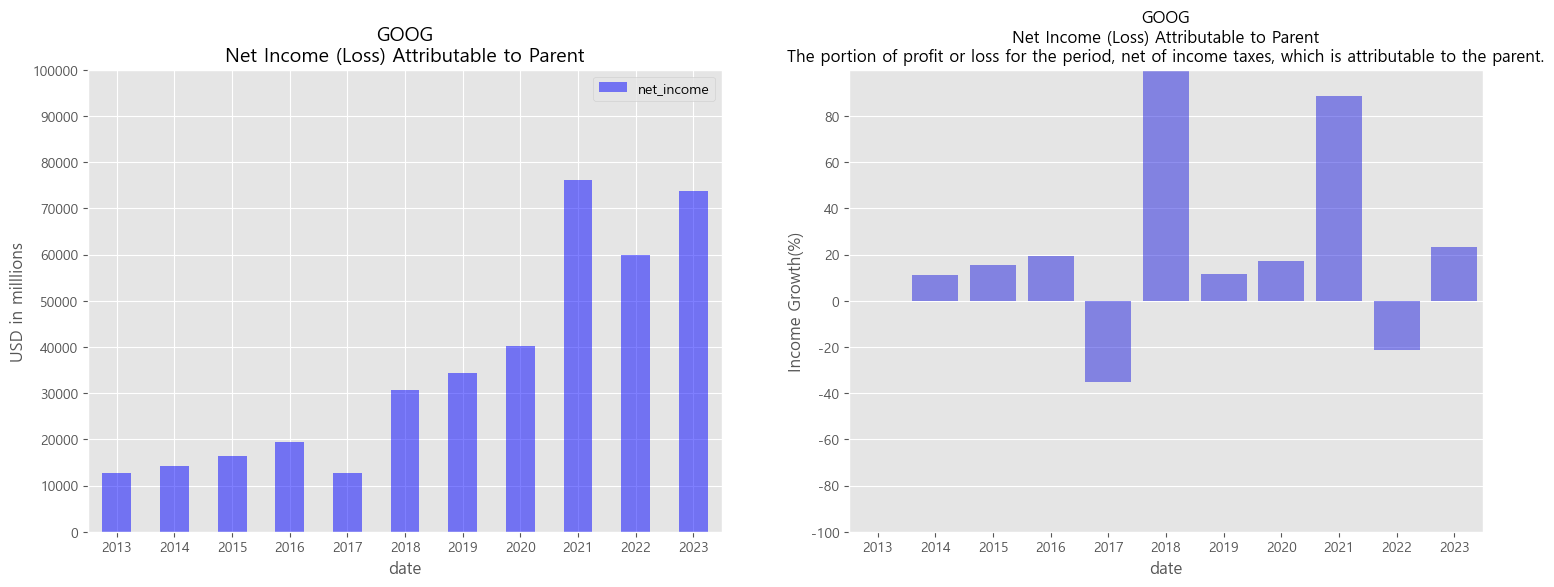

In [71]:
# Income Graphs
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Annual Net Income
df_net_income, title, description =  annual_net_income(facts)

plot_annual_net_income(df_net_income=df_net_income, title=title, description=description,
                       ymin=0, ymax=110000, ystep=10000, ax=axes[0])

# Net Income Growth
df_net_income['net_income_growth'] = df_net_income['net_income'].diff() / df_net_income['net_income'].abs().shift() * 100

plot_net_income_growth(df_net_income=df_net_income, title=title, description=description,
                       ymin=-100, ymax=100, ystep=20, ax=axes[1])

# Visualize
plt.show()

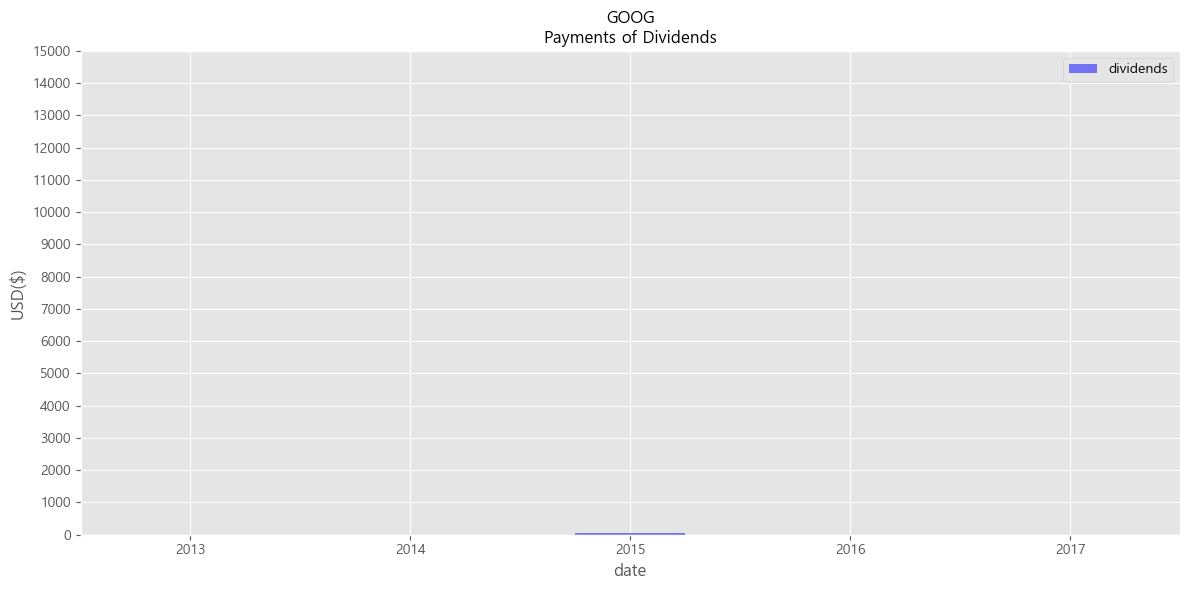

In [73]:
try:
    df_dividends, title, description = annual_dividends(facts)

    plot_annual_dividends(df_dividends, title, description, 
                        ymin=0, ymax=16000, ystep=1000)
except:
    print(f'{ticker} does not pay dividends')

### KO


### MSFT


In [74]:
ticker = 'MSFT'
facts = edgar.get_company_facts(cik=CIK[ticker.upper()])['facts']

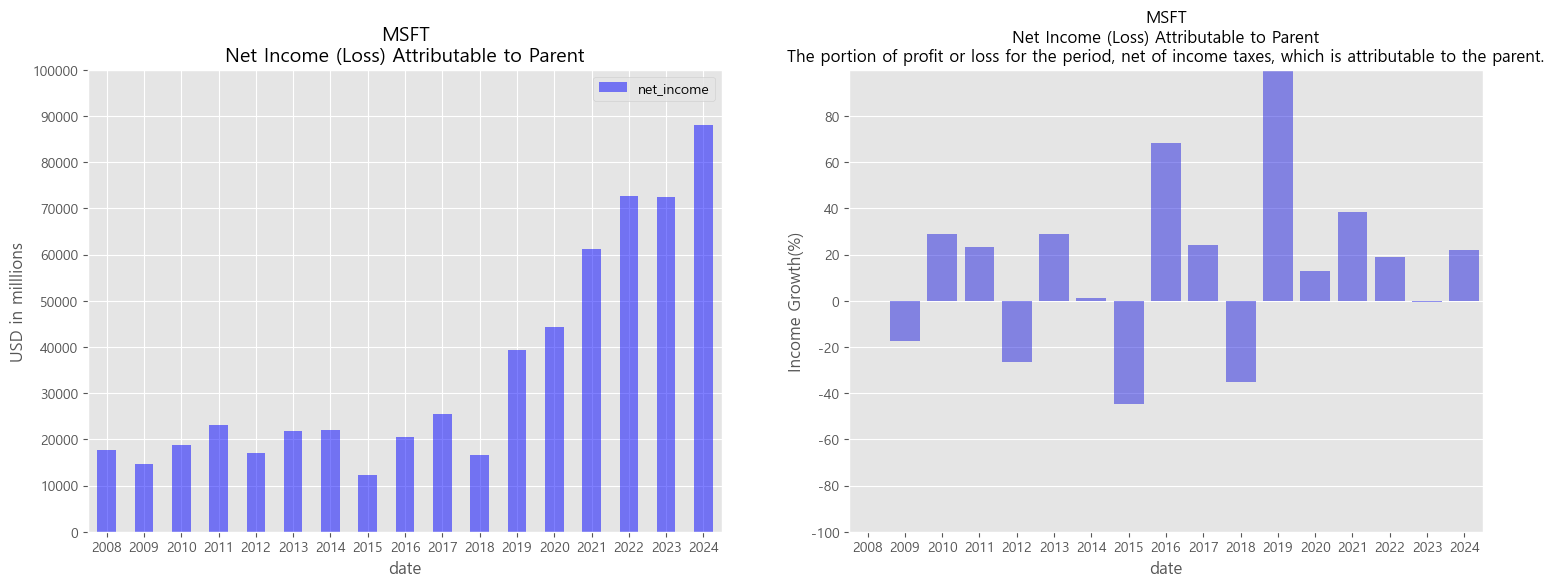

In [75]:
# Income Graphs
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Annual Net Income
df_net_income, title, description =  annual_net_income(facts)

plot_annual_net_income(df_net_income=df_net_income, title=title, description=description,
                       ymin=0, ymax=110000, ystep=10000, ax=axes[0])

# Net Income Growth
df_net_income['net_income_growth'] = df_net_income['net_income'].diff() / df_net_income['net_income'].abs().shift() * 100

plot_net_income_growth(df_net_income=df_net_income, title=title, description=description,
                       ymin=-100, ymax=100, ystep=20, ax=axes[1])

# Visualize
plt.show()

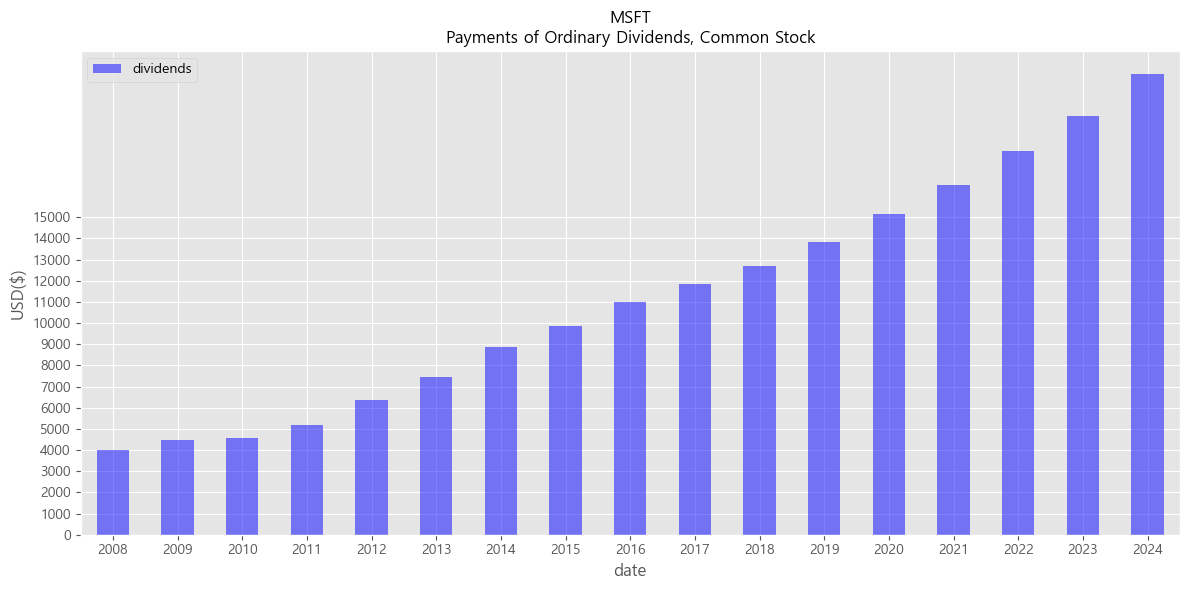

In [76]:
try:
    df_dividends, title, description = annual_dividends(facts)

    plot_annual_dividends(df_dividends, title, description, 
                        ymin=0, ymax=16000, ystep=1000)
except:
    print(f'{ticker} does not pay dividends')

### NVDA


In [77]:
ticker = 'NVDA'
facts = edgar.get_company_facts(cik=CIK[ticker.upper()])['facts']

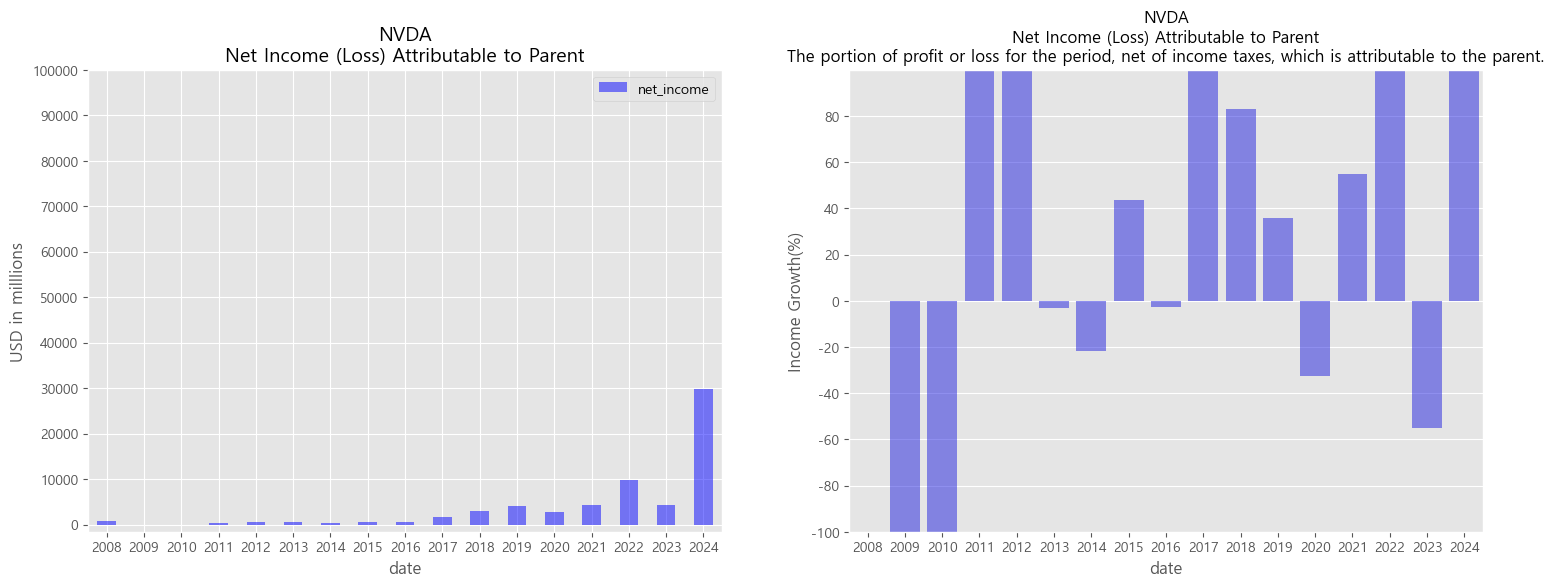

In [78]:
# Income Graphs
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Annual Net Income
df_net_income, title, description =  annual_net_income(facts)

plot_annual_net_income(df_net_income=df_net_income, title=title, description=description,
                       ymin=0, ymax=110000, ystep=10000, ax=axes[0])

# Net Income Growth
df_net_income['net_income_growth'] = df_net_income['net_income'].diff() / df_net_income['net_income'].abs().shift() * 100

plot_net_income_growth(df_net_income=df_net_income, title=title, description=description,
                       ymin=-100, ymax=100, ystep=20, ax=axes[1])

# Visualize
plt.show()

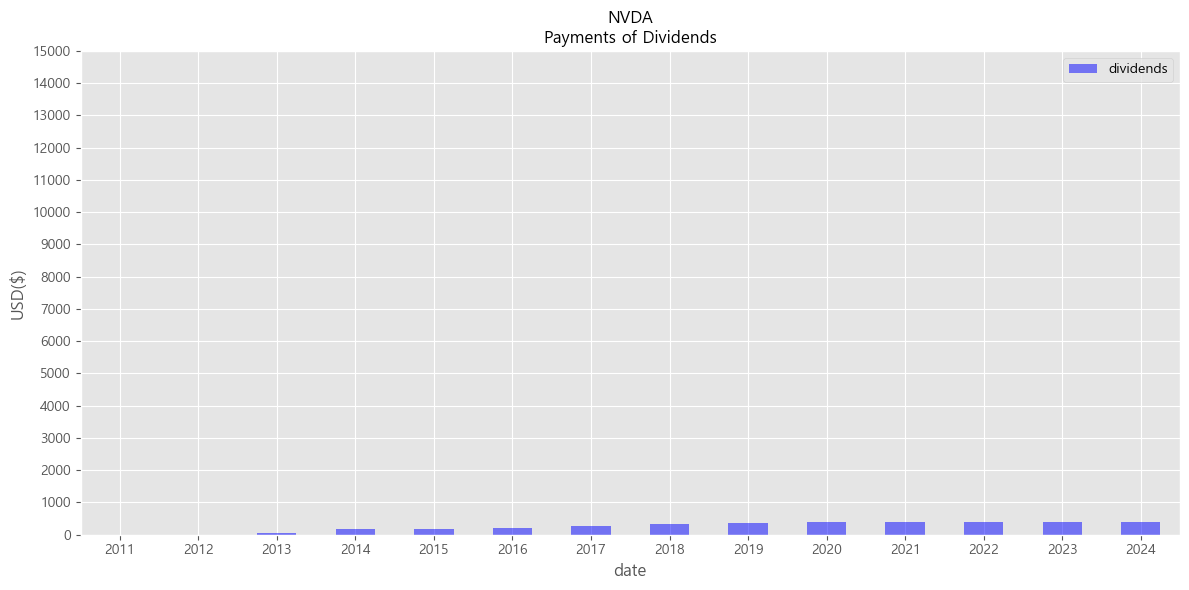

In [79]:
try:
    df_dividends, title, description = annual_dividends(facts)

    plot_annual_dividends(df_dividends, title, description, 
                        ymin=0, ymax=16000, ystep=1000)
except:
    print(f'{ticker} does not pay dividends')

### TSLA


In [80]:
ticker = 'TSLA'
facts = edgar.get_company_facts(cik=CIK[ticker.upper()])['facts']

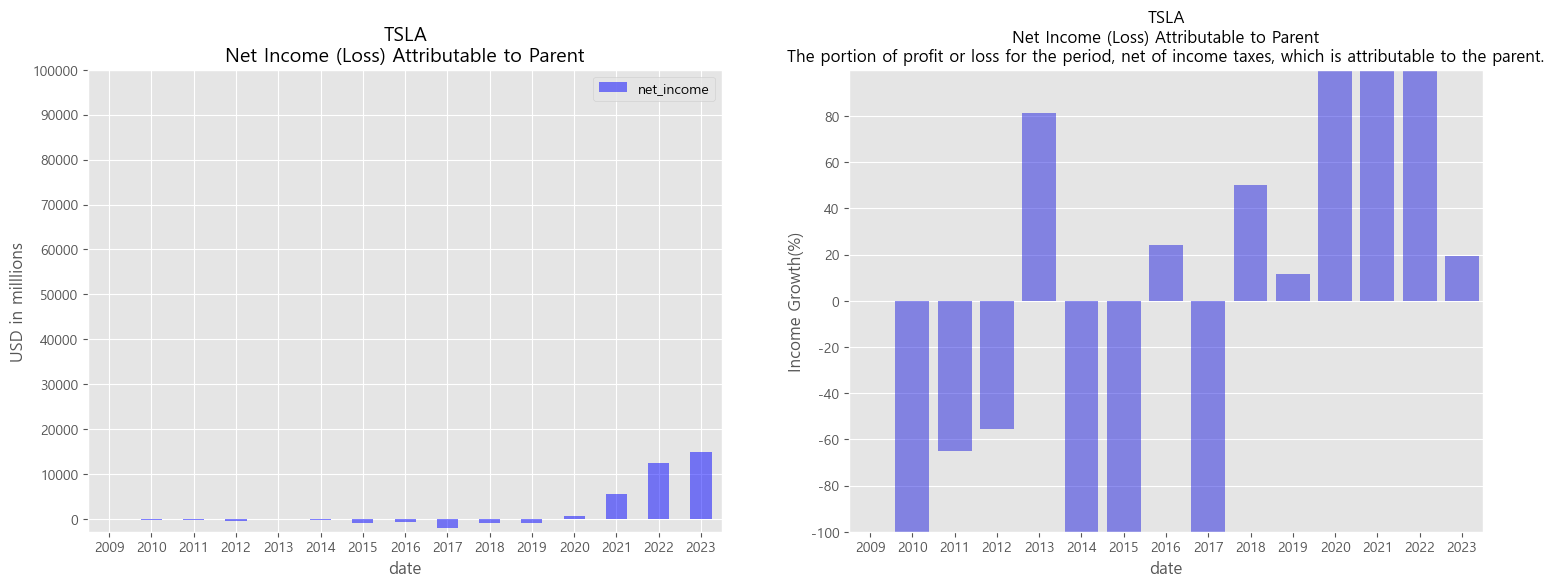

In [81]:
# Income Graphs
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Annual Net Income
df_net_income, title, description =  annual_net_income(facts)

plot_annual_net_income(df_net_income=df_net_income, title=title, description=description,
                       ymin=0, ymax=110000, ystep=10000, ax=axes[0])

# Net Income Growth
df_net_income['net_income_growth'] = df_net_income['net_income'].diff() / df_net_income['net_income'].abs().shift() * 100

plot_net_income_growth(df_net_income=df_net_income, title=title, description=description,
                       ymin=-100, ymax=100, ystep=20, ax=axes[1])

# Visualize
plt.show()

In [82]:
try:
    df_dividends, title, description = annual_dividends(facts)

    plot_annual_dividends(df_dividends, title, description, 
                        ymin=0, ymax=16000, ystep=1000)
except:
    print(f'{ticker} does not pay dividends')

TSLA does not pay dividends


### V

In [83]:
ticker = 'V'
facts = edgar.get_company_facts(cik=CIK[ticker.upper()])['facts']

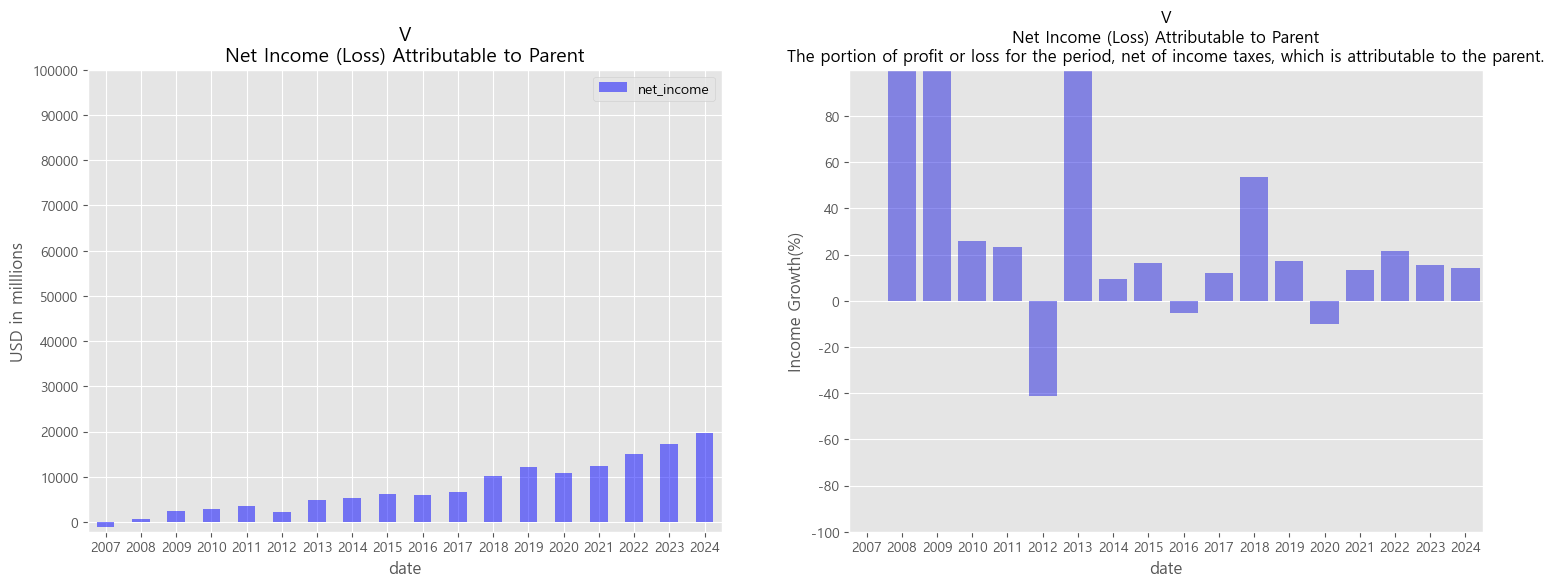

In [84]:
# Income Graphs
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Annual Net Income
df_net_income, title, description =  annual_net_income(facts)

plot_annual_net_income(df_net_income=df_net_income, title=title, description=description,
                       ymin=0, ymax=110000, ystep=10000, ax=axes[0])

# Net Income Growth
df_net_income['net_income_growth'] = df_net_income['net_income'].diff() / df_net_income['net_income'].abs().shift() * 100

plot_net_income_growth(df_net_income=df_net_income, title=title, description=description,
                       ymin=-100, ymax=100, ystep=20, ax=axes[1])

# Visualize
plt.show()

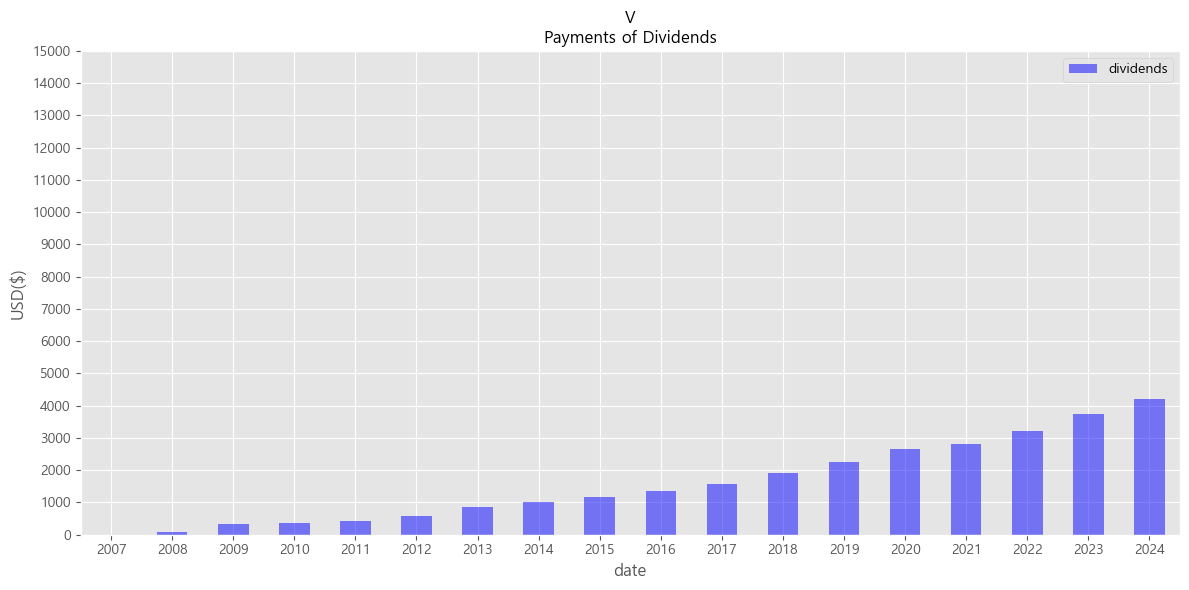

In [85]:
try:
    df_dividends, title, description = annual_dividends(facts)

    plot_annual_dividends(df_dividends, title, description, 
                        ymin=0, ymax=16000, ystep=1000)
except:
    print(f'{ticker} does not pay dividends')

## 2. Candidates

### ADBE


### AMD


### FB


### INTC


### MA

### MMM


### NFLX


### PEP


### SBUX